In [7]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter
import seaborn as sns
from cycler import cycler

from dask import delayed, compute
from dask.distributed import Client, as_completed
import gc
import itertools
from typing import Optional, Tuple, List, Union
import time

# Modeling
from arch import arch_model

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df

from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, Dropout, Flatten, GRU, Input, LSTM, MaxPooling1D 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [8]:
# Change formatting for images
%matplotlib inline

font_path = r'C:\Windows\Fonts\GIL_____.ttf'
fm.fontManager.addfont(font_path)
custom_font = fm.FontProperties(fname=font_path).get_name()

plt.rcParams['axes.prop_cycle'] = cycler(color=['#6C5B7B'])
background_color = (240/255, 240/255, 240/255)
plt.rcParams['figure.facecolor'] = background_color
plt.rcParams['axes.facecolor'] = background_color
plt.rcParams['font.family'] = custom_font

In [9]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.max_info_rows', 100)

In [10]:
# Read in prepared data
df_311_calls = pd.read_pickle('Data/311_Calls.pickle')
df_zips = pd.read_pickle('Data/NYC_Zips.pickle')
df_weather = pd.read_pickle('Data/NYC_Weather.pickle')

In [12]:
time_series = df_311_calls.groupby('Date',observed=True).size()

In [15]:
weekly.count()

Date
2010-01-03    3
2010-01-10    7
2010-01-17    7
2010-01-24    7
2010-01-31    7
2010-02-07    7
2010-02-14    7
2010-02-21    7
2010-02-28    7
2010-03-07    7
2010-03-14    7
2010-03-21    7
2010-03-28    7
2010-04-04    7
2010-04-11    7
2010-04-18    7
2010-04-25    7
2010-05-02    7
2010-05-09    7
2010-05-16    7
2010-05-23    7
2010-05-30    7
2010-06-06    7
2010-06-13    7
2010-06-20    7
2010-06-27    7
2010-07-04    7
2010-07-11    7
2010-07-18    7
2010-07-25    7
2010-08-01    7
2010-08-08    7
2010-08-15    7
2010-08-22    7
2010-08-29    7
2010-09-05    7
2010-09-12    7
2010-09-19    7
2010-09-26    7
2010-10-03    7
2010-10-10    7
2010-10-17    7
2010-10-24    7
2010-10-31    7
2010-11-07    7
2010-11-14    7
2010-11-21    7
2010-11-28    7
2010-12-05    7
2010-12-12    7
2010-12-19    7
2010-12-26    7
2011-01-02    7
2011-01-09    7
2011-01-16    7
2011-01-23    7
2011-01-30    7
2011-02-06    7
2011-02-13    7
2011-02-20    7
2011-02-27    7
2011-03-06    7
201

In [11]:
# Scaling functions for weather data

# log transform with a small constant
def log_transform(series, constant=1e-6):
    return np.log(series + constant)

# Helper function to apply Box-Cox transformation
def boxcox_transform(series):
    series_nonzero = series + 1e-6  # Add small constant to avoid zero values
    transformed_data, _ = boxcox(series_nonzero)
    return pd.Series(transformed_data, index=series.index)

# Seasonal decompose and recompose function
def decompose_and_scale(series, period=365):
    series = series.dropna()  # Drop NaNs if any
    decomposition = seasonal_decompose(series, model='additive', period=period)
    seasonal = decomposition.seasonal
    adjusted_series = series - seasonal  # Adjust the original series by removing the seasonal component

    scaler = StandardScaler()
    scaled_series = scaler.fit_transform(adjusted_series.values.reshape(-1, 1))

    scaled_series_full = pd.Series(scaled_series.flatten(), index=adjusted_series.index)
    scaled_series_full = scaled_series_full.reindex(series.index).bfill().ffill()

    return scaled_series_full

In [6]:
# Applying transformations

# Temperature columns: seasonal decompose, scale, recompose
df_weather['temperature_2m_max_scaled'] = decompose_and_scale(df_weather['temperature_2m_max'])
df_weather['temperature_2m_min_scaled'] = decompose_and_scale(df_weather['temperature_2m_min'])
df_weather['temperature_2m_mean_scaled'] = decompose_and_scale(df_weather['temperature_2m_mean'])

# Daylight duration: MinMax scale
df_weather['daylight_duration_scaled'] = MinMaxScaler().fit_transform(df_weather['daylight_duration'].values.reshape(-1, 1))

# Rainfall and Snowfall: Log transform with small constant
df_weather['rain_sum_log'] = boxcox_transform(df_weather['rain_sum'])
df_weather['snowfall_sum_log'] = boxcox_transform(df_weather['snowfall_sum'])

# Wind speed: Log transform
df_weather['wind_speed_10m_max_log'] = boxcox_transform(df_weather['wind_speed_10m_max'])

df_weather.drop(columns=['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
                         'daylight_duration', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max'], inplace=True)

df_weather.rename(columns={
    'temperature_2m_max_scaled': 'temperature_2m_max',
    'temperature_2m_min_scaled': 'temperature_2m_min',
    'temperature_2m_mean_scaled': 'temperature_2m_mean',
    'daylight_duration_scaled': 'daylight_duration',
    'rain_sum_log': 'rain_sum',
    'snowfall_sum_log': 'snowfall_sum',
    'wind_speed_10m_max_log': 'wind_speed_10m_max'
}, inplace=True)

In [16]:
target_cols = ['Agency', 'Type']
cols_to_drop = ['Zip', 'Borough']
df_311_calls_drop = df_311_calls.drop(columns=cols_to_drop, axis=1)
df_311_encoded = pd.get_dummies(df_311_calls_drop, columns=target_cols)
time_series = df_311_encoded.groupby('Date').sum()
time_series['Count'] = df_311_encoded.groupby('Date').size()

CPU times: total: 672 ms
Wall time: 681 ms


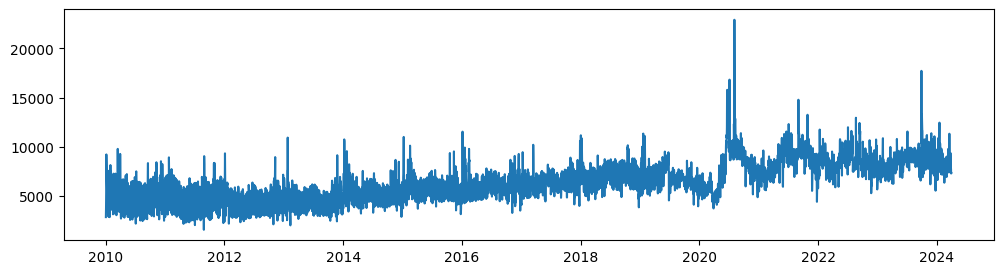

In [29]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(time_series['Count']);

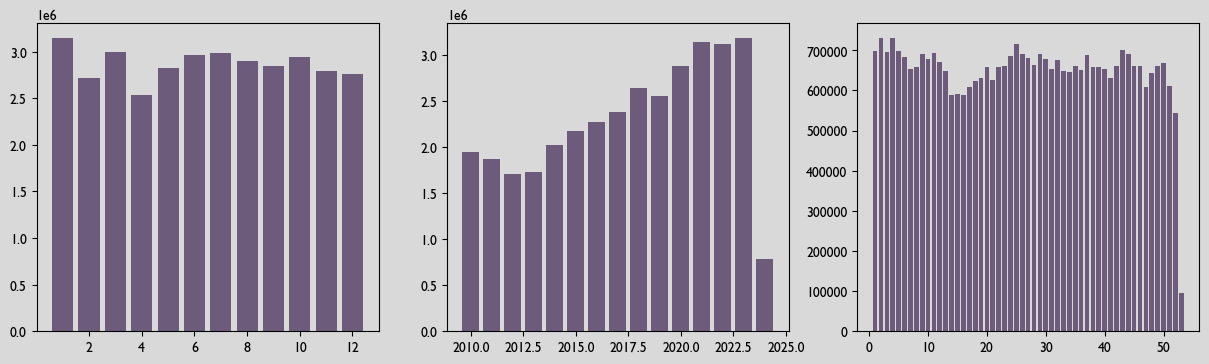

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
ax1.bar(x=df_311_calls['Date'].dt.month.value_counts().index, height=df_311_calls['Date'].dt.month.value_counts())
ax2.bar(x=df_311_calls['Date'].dt.year.value_counts().index, height=df_311_calls['Date'].dt.year.value_counts())
ax3.bar(x=df_311_calls['Date'].dt.isocalendar().week.value_counts().index, height=df_311_calls['Date'].dt.isocalendar().week.value_counts());

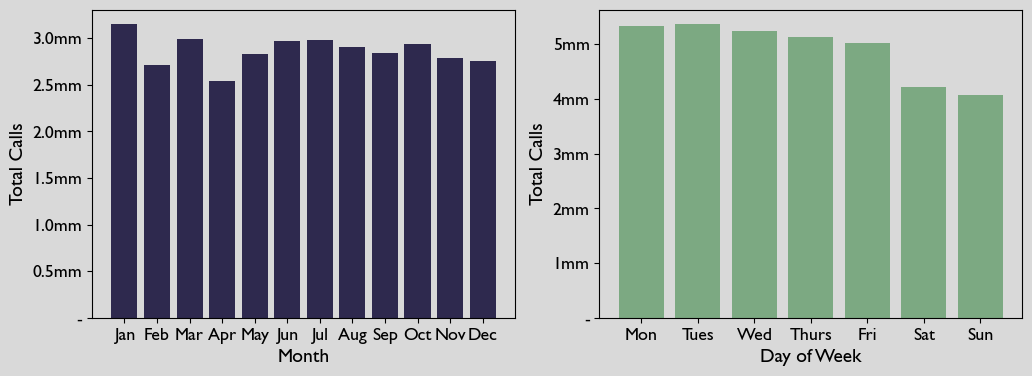

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
months = df_311_calls['Date'].dt.month.value_counts()
ax1.bar(x=months.index, height=months, color='#2E294E')
day_week = df_311_calls['Date'].dt.day_of_week.value_counts() 
ax2.bar(x=day_week.index, height=day_week, color='#7CA982')

x1_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y1_labels = ['-', '0.5mm', '1.0mm', '1.5mm', '2.0mm', '2.5mm', '3.0mm']
x2_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
y2_labels = ['-', '1mm', '2mm', '3mm', '4mm', '5mm']

ax1.set_xlabel('Month', fontsize=14)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(x1_labels, fontsize=13)
ax1.set_ylabel('Total Calls', fontsize=14)
ax1.set_yticks(range(0, 3500000, 500000))
ax1.set_yticklabels(y1_labels, fontsize=13)

ax2.set_xlabel('Day of Week', fontsize=14)
ax2.set_xticks(range(7))
ax2.set_xticklabels(x2_labels, fontsize=13)
ax2.set_ylabel('Total Calls', fontsize=14)
ax2.set_yticks(range(0, 6000000, 1000000))
ax2.set_yticklabels(y2_labels, fontsize=13)

plt.show()

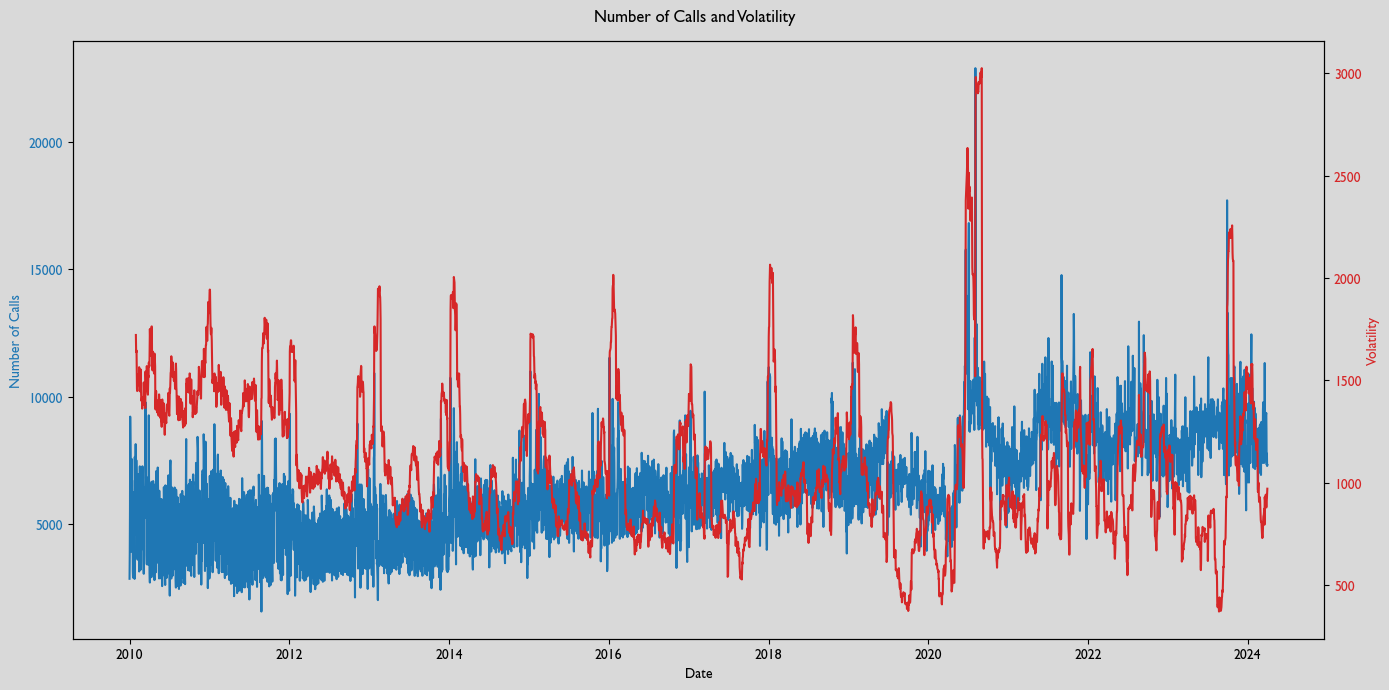

In [41]:
daily = pd.DataFrame(df_311_calls.groupby('Date', observed=True).size(), columns=['Count'])

window_size = 30
daily['Volatility'] = daily['Count'].rolling(window=window_size).std()

fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Calls', color='tab:blue')
ax1.plot(daily.index, daily['Count'], color='tab:blue', label='Number of Calls')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volatility', color='tab:red')
ax2.plot(daily.index, daily['Volatility'], color='tab:red', label='Volatility (30-day std)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and show the plot
fig.suptitle('Number of Calls and Volatility')
fig.tight_layout()

plt.show()

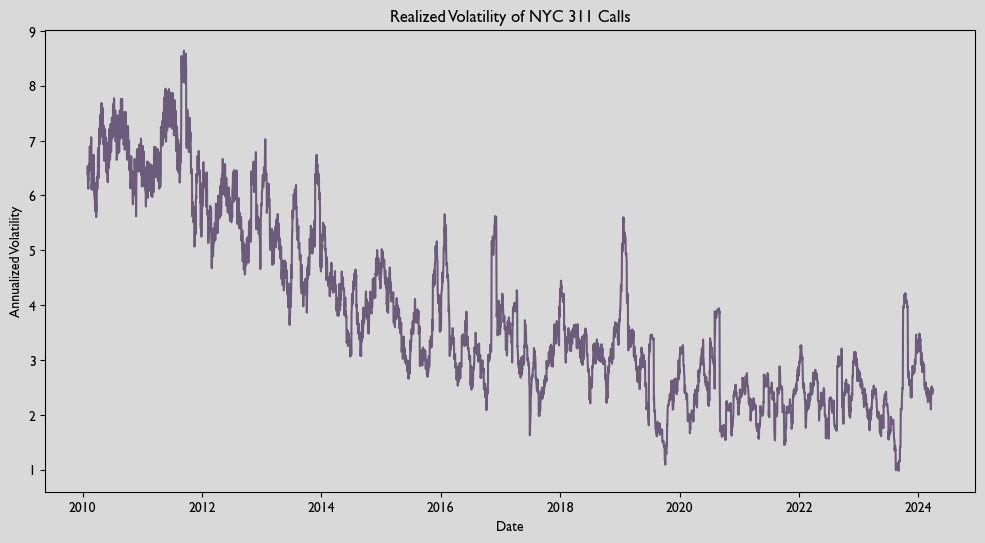

In [42]:
# Calculate the daily log returns
daily['log_returns'] = np.log(daily['Count'] / daily['Count'].shift(1))

# Calculate the realized volatility using a rolling window of 30 days
daily['realized_vol'] = daily['log_returns'].rolling(30).std() * np.sqrt(365)

# Plot the realized volatility
plt.figure(figsize=(12, 6))
plt.plot(daily.index, daily['realized_vol'])
plt.title('Realized Volatility of NYC 311 Calls')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()

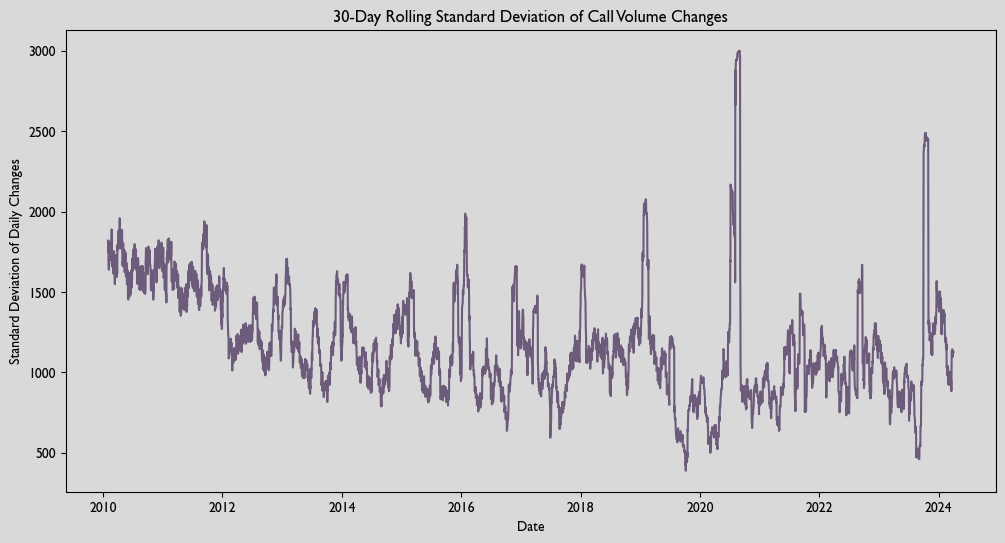

In [44]:
daily['rolling_std'] = daily['daily_change'].rolling(30).std()
plt.figure(figsize=(12,6))
plt.plot(daily.index, daily['rolling_std'])
plt.title('30-Day Rolling Standard Deviation of Call Volume Changes')
plt.xlabel('Date')
plt.ylabel('Standard Deviation of Daily Changes')
plt.show()

In [54]:
weekly = time_series.resample('W-SUN').sum()
monthly = time_series.resample('ME').sum()
quarterly = time_series.resample('QE').sum()
yearly = time_series.resample('YE').sum()

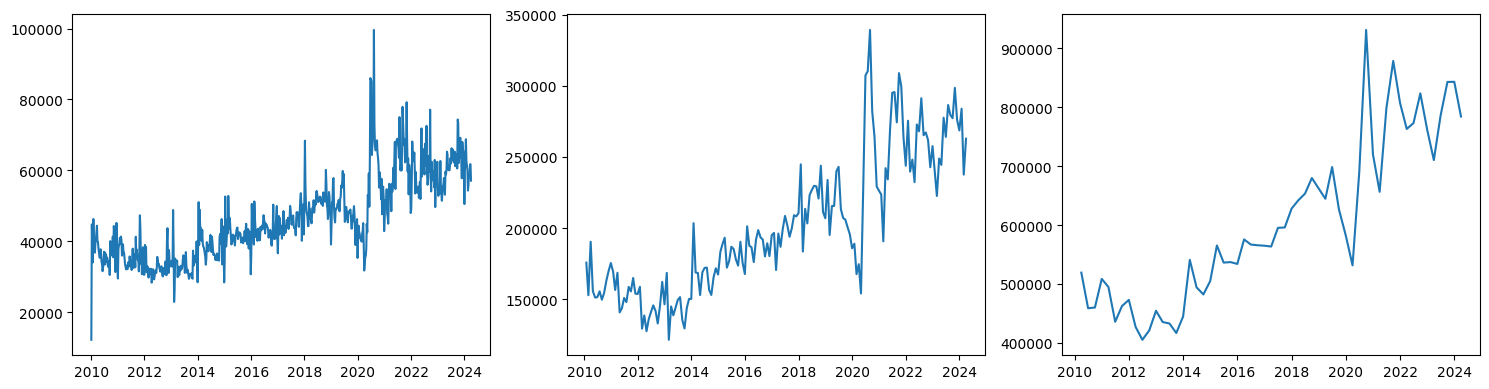

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
ax1.plot(weekly['Count'])
ax2.plot(monthly['Count'])
ax3.plot(quarterly['Count'])

fig.tight_layout();

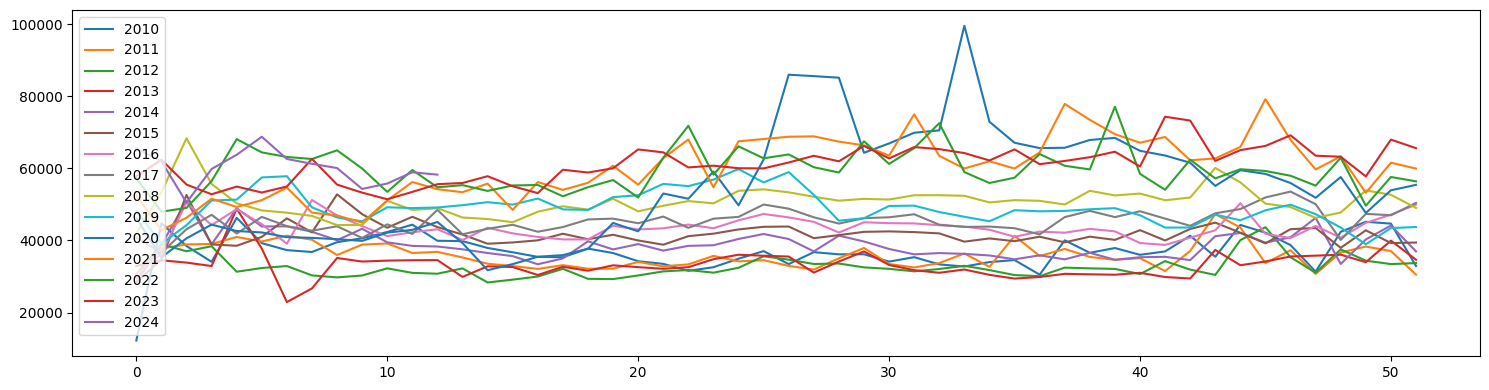

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,4))
ax.plot(weekly['Count'][:52].reset_index(drop=True), label='2010')
ax.plot(weekly['Count'][52:104].reset_index(drop=True), label='2011')
ax.plot(weekly['Count'][104:156].reset_index(drop=True), label='2012')
ax.plot(weekly['Count'][156:208].reset_index(drop=True), label='2013')
ax.plot(weekly['Count'][208:260].reset_index(drop=True), label='2014')
ax.plot(weekly['Count'][260:312].reset_index(drop=True), label='2015')
ax.plot(weekly['Count'][312:364].reset_index(drop=True), label='2016')
ax.plot(weekly['Count'][364:416].reset_index(drop=True), label='2017')
ax.plot(weekly['Count'][416:468].reset_index(drop=True), label='2018')
ax.plot(weekly['Count'][468:520].reset_index(drop=True), label='2019')
ax.plot(weekly['Count'][520:572].reset_index(drop=True), label='2020')
ax.plot(weekly['Count'][572:624].reset_index(drop=True), label='2021')
ax.plot(weekly['Count'][624:676].reset_index(drop=True), label='2022')
ax.plot(weekly['Count'][676:728].reset_index(drop=True), label='2023')
ax.plot(weekly['Count'][728:741].reset_index(drop=True), label='2024')
plt.legend(loc='upper left')
fig.tight_layout();

In [137]:
agency_cols = monthly.filter(like='Agency').columns.tolist()

monthly_police = monthly['Agency_Police']
monthly_housing = monthly['Agency_Housing']
monthly_sanitation = monthly['Agency_Sanitation']
monthly_transportation = monthly['Agency_Sanitation']
monthly_parks = monthly['Agency_Parks']
monthly_environment = monthly['Agency_Environment']

monthly_other = monthly[agency_cols].sum().sort_values(ascending=False).index.tolist()
monthly_other

['Agency_Police',
 'Agency_Housing',
 'Agency_Sanitation',
 'Agency_Transportation',
 'Agency_Environment',
 'Agency_Parks',
 'Agency_Buildings',
 'Agency_Other',
 'Agency_Finance',
 'Agency_Taxi',
 'Agency_Homeless',
 'Agency_Consumer',
 'Agency_Human Resources']

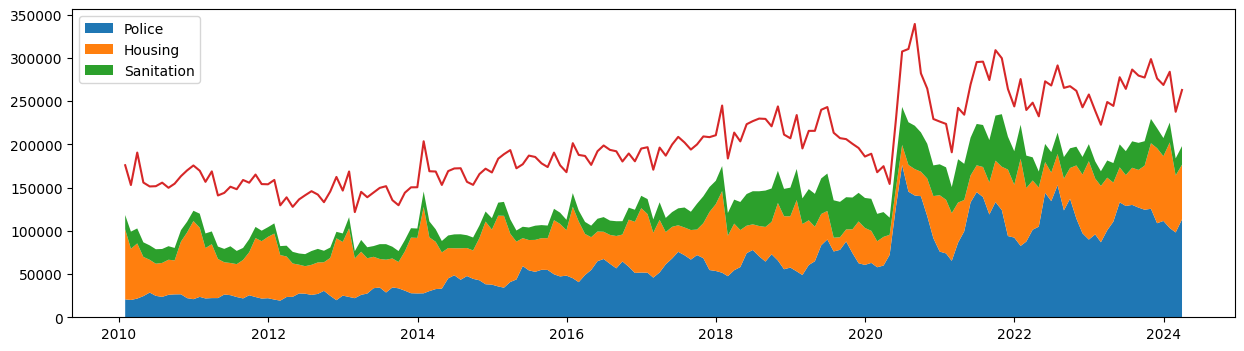

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,4))
ax.stackplot(monthly.index, monthly_police, monthly_housing, monthly_sanitation, labels=['Police','Housing','Sanitation'])
ax.plot(monthly['Count'])
plt.legend(loc='upper left');

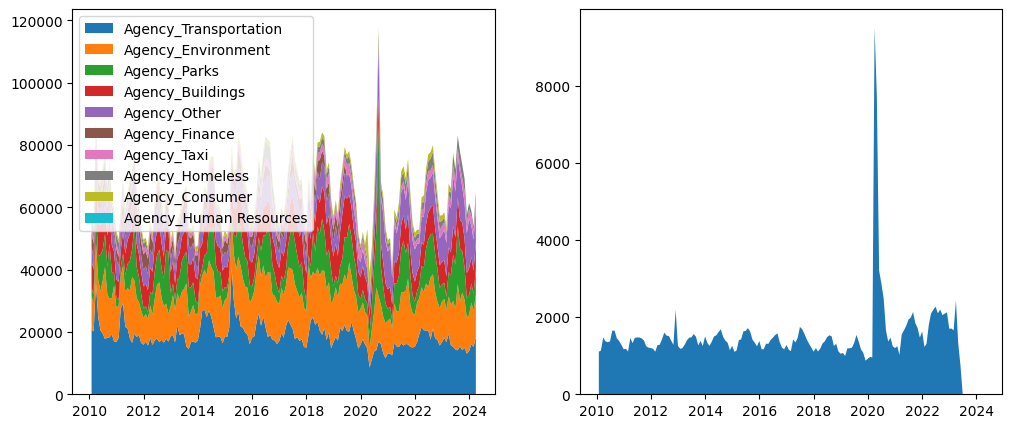

In [115]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
ax1.stackplot(monthly.index,monthly[monthly_other].T, labels=monthly_other)
ax1.legend(loc='upper left')
ax2.stackplot(monthly.index,monthly['Agency_Consumer']);

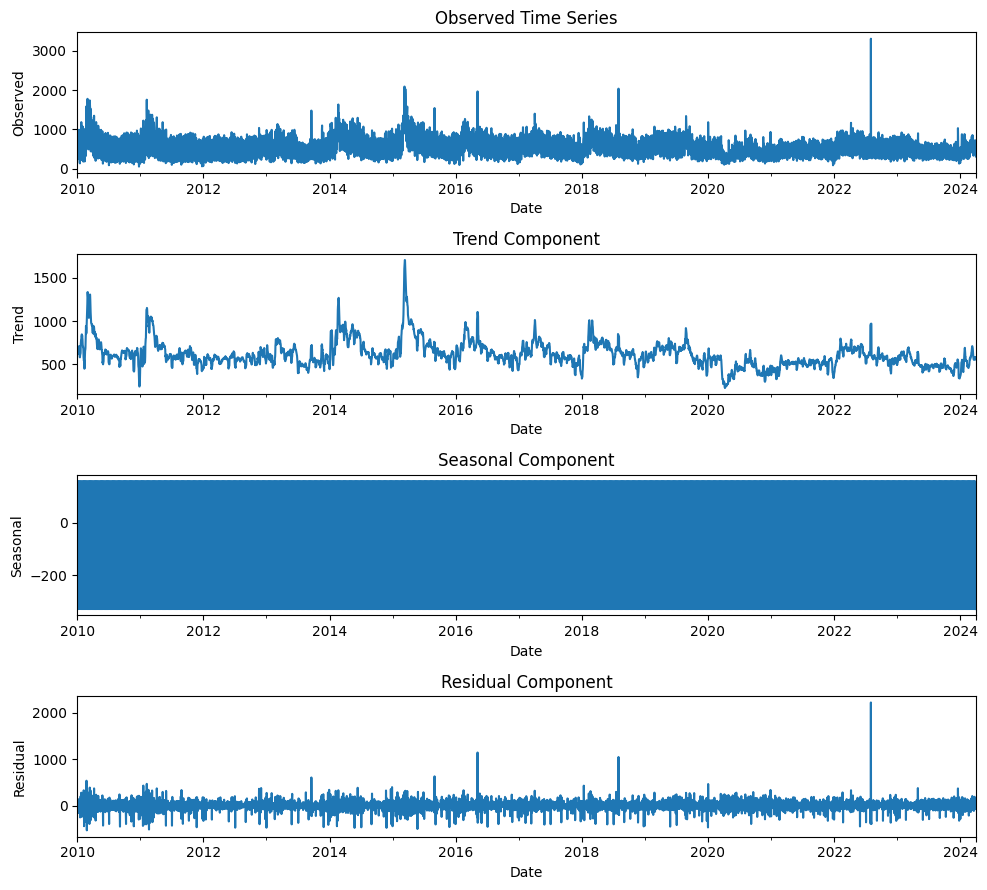

In [150]:
# Decompose the time series
agency = time_series['Agency_Transportation']
decomposition = seasonal_decompose(agency, model='additive', period=7)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 9))

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Observed Time Series')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax2.set_title('Trend Component')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal Component')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()